In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

### Inference in Pyro: From Stochastic Functions to Marginal Distributions
    Stochastic functions induce a joint probability distribution p(y,z|x) 
    Induces a marginal distribution over return values of the function
    
    Much of modern machine learning can be cast as approximate Bayesian inference and expressed succinctly in a language like Pyro.
    
    I can't understand XD
    

### A Simple Example
    Suppose we are trying to figure out how much something weighs, but the scale we’re using is unreliable and gives slightly different answers every time we weigh the same object. 
#### We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some prior knowledge about the object
    用加上noise的方式，以及一些prior knowledge，去approximate    


In [2]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # fluctuates 變動
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

### Representing Marginal Distributions
#### Marginal Distributions: It contrasts with conditional distrubition. It gives prababilistics of variables without reference to vales of others

    Marginalization in Pyro with pyro.infer.Marginal is split into two steps. 
    First, we collect a number of weighted execution traces of the model.
    Then, we can collapse those traces into a histogram over possible return values given a particular set of arguments.
    (In order to do marginal distributions)

In [6]:
posterior = pyro.infer.Importance(scale, num_samples=100)


In [12]:
# By this usage, we can get output like before
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)
print(marginal(guess))

Variable containing:
 8.2103
[torch.FloatTensor of size 1]



Text(0,0.5,'#')

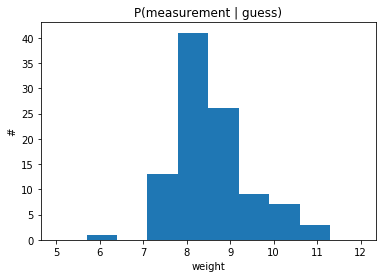

In [10]:

plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

### Conditioning Models on Data
##### The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data

    Pyro provides the function pyro.condition to allow us to constrain the values of sample statements.

In [14]:
# Behaves like python function , but "measurement" is fixed
conditioned_scale = pyro.condition(
    scale, data={"measurement": Variable(torch.Tensor([8.5]))})

In [15]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

    Introduce many usages (I think is all the same )

In [16]:
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
     # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                       obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal, Variable(torch.ones(1)),
                        weight, Variable(torch.Tensor([0.1])))

In [17]:
def scale2(guess):
    weight = pyro.sample("weight", dist.normal,
                         guess, Variable(torch.ones(1)))
    tolerance = torch.abs(
        pyro.sample("tolerance", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1))))

    return pyro.sample("measurement", dist.normal, weight, tolerance)

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": Variable(torch.ones(1))}),
    data={"measurement": Variable(torch.ones(1))})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": Variable(torch.ones(1))}),
    data={"weight": Variable(torch.ones(1))})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": Variable(torch.ones(1)), "measurement": Variable(torch.ones(1))})

### Flexible Approximate Inference With Guide Functions
    Let’s return to deferred_conditioned_scale.

{'weight': Variable containing:
 7.8769
[torch.FloatTensor of size 1]
}


Text(0,0.5,'#')

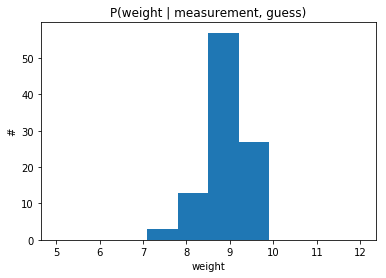

In [25]:
guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

# assign sites: want to see sites in marginal distributions 
marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

# The marginal distribution concentrates around the data
print(marginal(guess))
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

    Some inference algorithms in Pyro, like pyro.infer.Importance and pyro.infer.SVI, allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions.
    Guide functions must satisfy these two criteria to be valid approximations for a particular model: 
        1. all unobserved sample statements that appear in the model appear in the guide. 
        2. the guide has the same input signature as the model (i.e. takes the same arguments)

In [26]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))

# compared to above code
# posterior = pyro.infer.Importance(scale, num_samples=100)
posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])

   　More true posterior distribution 

Text(0,0.5,'#')

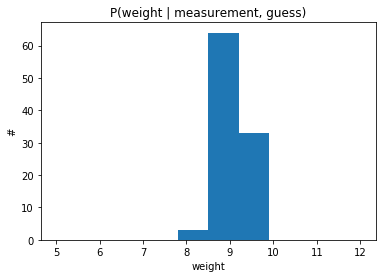

In [29]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.normal, a, b)

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

### Parametrized Stochastic Functions and Variational Inference
#### variational inference: Use the top-level function pyro.param to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation

In [30]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))

In [32]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))

    Using SVI (will be intruduced in next chapter)

Text(0,0.5,'loss')

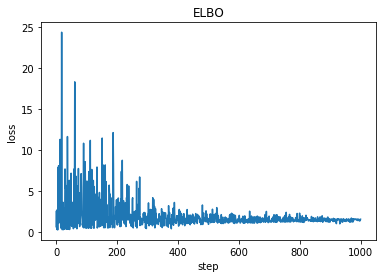

In [33]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss="ELBO")

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

    For example, we can use the optimized guide as an importance distribution for estimating the marginal distribution over weight with many fewer samples than the prior:

Text(0,0.5,'#')

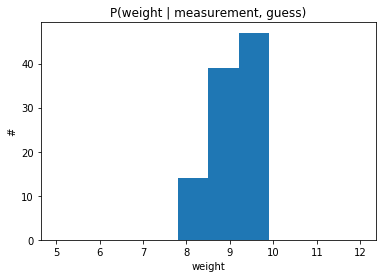

In [34]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

Text(0,0.5,'#')

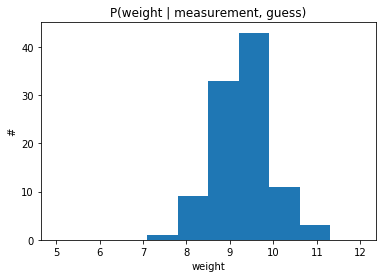

In [35]:
plt.hist([scale_parametrized_guide(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")